# Homework 2

参与者：盛文哲，刘任达

In [28]:
import pandas as pd
import numpy as np

# 读取数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# 随机展示10行
print(train_data.sample(n=100))
print(test_data.sample(n=100))

                                                      seq     label
153288  ACCCGCAAAACACTGCGTCGCGGTCTGAAGTTAGGCGGTGAAGGTA...  0.274617
37867   CCGAAAGGCAAGTAGAGGAAGGAGAGAGCCGTCATGTGGCGTGTCC... -1.849192
219999  TACTGAACGTCGGGTGACCGTCATCGAGACGAGCGTCGCAGACCCA...  0.342394
216139  AACCCCCTACGTTCAGGTCTAGTAGGTGCGTAATTTGTACAGGTTT... -0.016039
227828  CGCCTCTGTCCGAGACAGGAGTGCTTATACCGGTAACCGTACGGCA...  0.515028
...                                                   ...       ...
256339  CCCCACGAGGGTTCCATTGACAGCAATACAGAACTTTCAACGAGGT...  0.778302
144994  CCGACGTGAGGTTTGTGGGGGCGGTTCGCAGGCCCAGACACCGGAA...  0.191711
1166    CTCGGGCGCCCCAAAAAAACCCATGAATCGGTTGGCACACGTGATC... -0.847331
153039  ATCTAAGCAGTGGACGTCAGCGGTGAAGGCGGGATTTAGAAGCACC...  0.616796
117115  AAGGCGGGCGAGAATACCCAAATTCAAGGGATGGCAATCTTGGATT... -1.058725

[100 rows x 2 columns]
                                                     seq     label
9545   TTGGCCCACTATCTCGAGGCTCAAGGCCACACGGCACTCTTCTATG...  0.291477
5057   CCACGAACGTACTTGGAGA

In [17]:
print(f"数据大小:{train_data.shape}")
print(f"列索引如下:")
print(train_data.columns) #基因、细胞种类数码与名称

数据大小:(260000, 2)
列索引如下:
Index(['seq', 'label'], dtype='object')


## 论文总结

人类mRNA的子序列5' UTR位于起始密码子之前，对基因翻译的效率有重要影响。此前，科学家已发现某些序列特征（如特定结构、起始密码子位置）影响翻译，但缺乏一种**通用方法**预测序列对翻译效率的影响，也无法精准设计5' UTR来调控蛋白质表达水平。本论文想要利用deep learning搭建一个CNN模型，对MRL（指单个mRNA分子上结合的核糖体数量的平均值）与基因片段的联系进行探究，从而反映基因表达的效率与片段的联系。

同时，文章构建的模型也有比较好的泛化能力，即对于蛋白质对应的编码序列（CDS）的选取仍有不错的适应性。模型既可以对eGFP蛋白达到93%的解释性，也在mCherry序列的预测上表现出78%左右的解释性；在包括$\Psi$和$m^1 \Psi$的模型中也有68%-76%的解释性。为了更细致的探究每个sequence的出现频率，文章还构建了一个polysome profiling模型来预测多具体分布，这个模型结构与第一个模型相似。

## 模型搭建

本论文搭建的模型名称是Optimus 5-Prime，是一个CNN模型。经过10-fold cross-validation的网格搜索选出超参数（卷积层数, filter lengths, filter个数, 节点数，dropout rate）

#### 初始数据和处理

280000个样本数据来自eGFP library，260000个作为训练集，20000个作为测试集。

每个数据包含基因片段信息和表达结果，基因片段是ATGC的排列，长度在25-100之间，通过one-hot编码转成$4\times n$的一个矩阵：A、T、G、C分别映为$(0,0,0,1),\ (0,1,0,0),\ (0,0,1,0),\ (0,0,0,1)$.

#### 第一卷积层

120个滤波器 (8 × 4), ReLU激活函数，0% dropout.

#### 第二卷积层

120个滤波器 (8 × 1), ReLU激活函数，0% dropout.

#### 第三卷积层

120个滤波器 (8 × 1), ReLU激活函数，0% dropout.

#### 全连接层

全连接到40个输出节点，dropout 20%防止过拟合。

#### 输出层

一个线性输出（如果是MRL Prediction模型）或者14个线性输出（如果是Polysome Profiling Model）
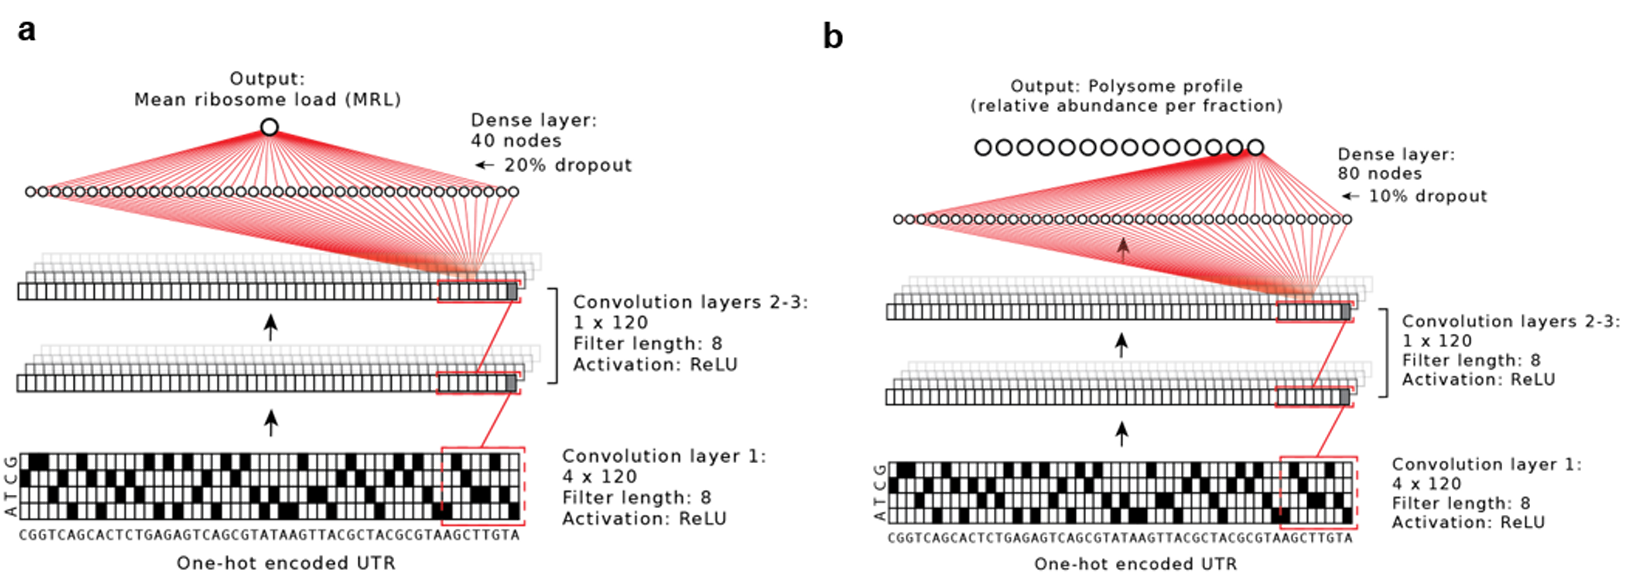




## CNN + Attention 模型

模型介绍：

#### 第一卷积层

输入为 DNA one-hot编码：形状 (20800, 4, 50)；输出为 64 个通道

Filter length = 8, Padding = 4 使输出长度保持（大致）不变

MaxPool将采样折半，以便提取更稳定的局部信息

#### 第二卷积层

输入为64个通道，输出为64个通道，激活函数为ReLU

Filter length = 5, Padding = 2

#### 第三卷积层

输入为64个通道，输出为128个通道，激活函数为ReLU

Filter length = 5, Padding = 2

再次MaxPool，提高感受野

#### Attention层

利用注意力机制抓大放小

dropout = 0.2，防止过拟合

#### 输出层

线性层：128 -> 64，加ReLU层，再映射为1维输出，这样逐步压缩特征，防止过拟合，同时增加非线性性增强模型的非线性解释能力


In [ ]:
#数据预处理
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split

def one_hot_encode(seq):
    mapping = {
        'A': [1,0,0,0],
        'T': [0,1,0,0],
        'C': [0,0,1,0],
        'G': [0,0,0,1],
        'N': [0,0,0,0]
    }
    try:
        matrix = np.array([mapping[char] for char in seq]).T
    except KeyError:
        raise ValueError(f"无效字符 '{e.args[0]}'，请输入只包含ATCG的序列") from None
    return matrix


def pre_process(data,batch_size=64):
    #分离特征和标签
    X = data.iloc[:,0].values
    X = np.array([one_hot_encode(x) for x in X])
    Y = data.iloc[:,1].values.astype(float)
    print(f"数据大小:{X.shape}")
    print(f"标签大小:{Y.shape}")

    #划分training_set validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X, Y, 
        test_size=0.2, #验证集占0.2
        random_state=42, 
    )
    # 转换为张量
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.FloatTensor(y_val)



    # 创建数据加载器
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader




In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Attention_Regressor(nn.Module):
    def __init__(self, input_len=50):
        super(CNN_Attention_Regressor, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=8, padding=4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.attn = nn.Linear(128, 1)  # attention score generator
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # x: (batch_size, 4, N)
        x = self.pool1(self.relu1(self.conv1(x)))  # -> (batch_size, 64, N/2)
        x = self.pool2(self.relu2(self.conv2(x)))  # -> (batch_size, 128, N/4)
        
        x = x.permute(0, 2, 1)  # -> (batch_size, N/4, 128)

        # attention: score over each position
        attn_weights = F.softmax(self.attn(x), dim=1)  # -> (batch_size, N/4, 1)
        attn_applied = torch.sum(attn_weights * x, dim=1)  # -> (batch_size, 128)
        
        out = self.dropout(attn_applied)
        out = self.fc(out)  # -> (batch_size, 1)
        return out.squeeze(1)
    


class CNN_Attention_Regressor1(nn.Module):
    def __init__(self, input_len=50):
        super(CNN_Attention_Regressor1, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=8, padding=4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        self.attn = nn.Linear(128, 1)  # attention score generator
        self.dropout = nn.Dropout(0.2)

        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # x: (batch_size, 4, N)
        x = self.pool1(self.relu1(self.conv1(x)))  # -> (batch_size, 64, N/2)
        x = self.relu2(self.conv2(x))  # -> (batch_size, 128, N/4)
        x = self.pool3(self.relu3(self.conv3(x)))  # -> (batch_size, 128, N/8)
        
        x = x.permute(0, 2, 1)  # -> (batch_size, N/4, 128)

        # attention: score over each position
        attn_weights = F.softmax(self.attn(x), dim=1)  # -> (batch_size, N/4, 1)
        attn_applied = torch.sum(attn_weights * x, dim=1)  # -> (batch_size, 128)
        
        out = self.dropout(attn_applied)
        out = self.fc(out)  # -> (batch_size, 1)
        return out.squeeze(1)


model 和 model1 分别是一个两层神经网络和三层神经网络，这里采用的batch_size = 64

In [44]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 1. 加载数据
train_loader, val_loader = pre_process(train_data, batch_size=64)

# 2. 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Attention_Regressor().to(device)

# 3. 损失函数与优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. 训练循环
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved.")

print("Training complete.")


数据大小:(260000, 4, 50)
标签大小:(260000,)


Epoch 1: 100%|██████████| 3250/3250 [00:19<00:00, 165.93it/s]


Epoch 1: Train Loss = 0.4881, Val Loss = 0.4071
Model saved.


Epoch 2: 100%|██████████| 3250/3250 [00:20<00:00, 155.35it/s]


Epoch 2: Train Loss = 0.3906, Val Loss = 0.3565
Model saved.


Epoch 3: 100%|██████████| 3250/3250 [00:22<00:00, 144.82it/s]


Epoch 3: Train Loss = 0.3558, Val Loss = 0.3397
Model saved.


Epoch 4: 100%|██████████| 3250/3250 [00:20<00:00, 159.31it/s]


Epoch 4: Train Loss = 0.3407, Val Loss = 0.3258
Model saved.


Epoch 5: 100%|██████████| 3250/3250 [00:18<00:00, 175.66it/s]


Epoch 5: Train Loss = 0.3291, Val Loss = 0.3170
Model saved.


Epoch 6: 100%|██████████| 3250/3250 [00:21<00:00, 150.28it/s]


Epoch 6: Train Loss = 0.3191, Val Loss = 0.3096
Model saved.


Epoch 7: 100%|██████████| 3250/3250 [00:22<00:00, 147.04it/s]


Epoch 7: Train Loss = 0.3104, Val Loss = 0.3020
Model saved.


Epoch 8: 100%|██████████| 3250/3250 [00:18<00:00, 173.61it/s]


Epoch 8: Train Loss = 0.2990, Val Loss = 0.2895
Model saved.


Epoch 9: 100%|██████████| 3250/3250 [00:19<00:00, 169.68it/s]


Epoch 9: Train Loss = 0.2903, Val Loss = 0.2854
Model saved.


Epoch 10: 100%|██████████| 3250/3250 [00:18<00:00, 176.01it/s]


Epoch 10: Train Loss = 0.2841, Val Loss = 0.2796
Model saved.


Epoch 11: 100%|██████████| 3250/3250 [00:19<00:00, 166.81it/s]


Epoch 11: Train Loss = 0.2793, Val Loss = 0.2788
Model saved.


Epoch 12: 100%|██████████| 3250/3250 [00:19<00:00, 163.96it/s]


Epoch 12: Train Loss = 0.2739, Val Loss = 0.2746
Model saved.


Epoch 13: 100%|██████████| 3250/3250 [00:20<00:00, 158.19it/s]


Epoch 13: Train Loss = 0.2705, Val Loss = 0.2707
Model saved.


Epoch 14: 100%|██████████| 3250/3250 [00:17<00:00, 181.22it/s]


Epoch 14: Train Loss = 0.2661, Val Loss = 0.2738


Epoch 15: 100%|██████████| 3250/3250 [00:18<00:00, 178.19it/s]


Epoch 15: Train Loss = 0.2643, Val Loss = 0.2683
Model saved.


Epoch 16: 100%|██████████| 3250/3250 [00:17<00:00, 182.08it/s]


Epoch 16: Train Loss = 0.2601, Val Loss = 0.2714


Epoch 17: 100%|██████████| 3250/3250 [00:17<00:00, 183.69it/s]


Epoch 17: Train Loss = 0.2576, Val Loss = 0.2687


Epoch 18: 100%|██████████| 3250/3250 [00:17<00:00, 187.04it/s]


Epoch 18: Train Loss = 0.2556, Val Loss = 0.2673
Model saved.


Epoch 19: 100%|██████████| 3250/3250 [00:17<00:00, 186.19it/s]


Epoch 19: Train Loss = 0.2524, Val Loss = 0.2687


Epoch 20: 100%|██████████| 3250/3250 [00:17<00:00, 189.61it/s]


Epoch 20: Train Loss = 0.2498, Val Loss = 0.2685
Training complete.


In [54]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 1. 加载数据
train_loader, val_loader = pre_process(train_data, batch_size=64)

# 2. 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = CNN_Attention_Regressor1().to(device)

# 3. 损失函数与优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

# 4. 训练循环
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model1.train()
    train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model1(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    # 验证
    model1.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model1(x)
            loss = criterion(outputs, y)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model1.state_dict(), "best_model.pth")
        print("Model saved.")

print("Training complete.")


数据大小:(260000, 4, 50)
标签大小:(260000,)


Epoch 1: 100%|██████████| 3250/3250 [00:20<00:00, 156.98it/s]


Epoch 1: Train Loss = 0.4367, Val Loss = 0.3242
Model saved.


Epoch 2: 100%|██████████| 3250/3250 [00:19<00:00, 167.55it/s]


Epoch 2: Train Loss = 0.3076, Val Loss = 0.2711
Model saved.


Epoch 3: 100%|██████████| 3250/3250 [00:19<00:00, 166.48it/s]


Epoch 3: Train Loss = 0.2743, Val Loss = 0.2507
Model saved.


Epoch 4: 100%|██████████| 3250/3250 [00:19<00:00, 163.39it/s]


Epoch 4: Train Loss = 0.2469, Val Loss = 0.2246
Model saved.


Epoch 5: 100%|██████████| 3250/3250 [00:19<00:00, 166.77it/s]


Epoch 5: Train Loss = 0.2255, Val Loss = 0.2062
Model saved.


Epoch 6: 100%|██████████| 3250/3250 [00:20<00:00, 161.11it/s]


Epoch 6: Train Loss = 0.2115, Val Loss = 0.2010
Model saved.


Epoch 7: 100%|██████████| 3250/3250 [00:19<00:00, 167.80it/s]


Epoch 7: Train Loss = 0.2012, Val Loss = 0.1951
Model saved.


Epoch 8: 100%|██████████| 3250/3250 [00:20<00:00, 157.31it/s]


Epoch 8: Train Loss = 0.1948, Val Loss = 0.1929
Model saved.


Epoch 9: 100%|██████████| 3250/3250 [00:19<00:00, 166.28it/s]


Epoch 9: Train Loss = 0.1887, Val Loss = 0.1888
Model saved.


Epoch 10: 100%|██████████| 3250/3250 [00:19<00:00, 164.23it/s]


Epoch 10: Train Loss = 0.1813, Val Loss = 0.1761
Model saved.


Epoch 11: 100%|██████████| 3250/3250 [00:19<00:00, 163.27it/s]


Epoch 11: Train Loss = 0.1715, Val Loss = 0.1683
Model saved.


Epoch 12: 100%|██████████| 3250/3250 [00:19<00:00, 168.87it/s]


Epoch 12: Train Loss = 0.1655, Val Loss = 0.1627
Model saved.


Epoch 13: 100%|██████████| 3250/3250 [00:19<00:00, 167.23it/s]


Epoch 13: Train Loss = 0.1604, Val Loss = 0.1600
Model saved.


Epoch 14: 100%|██████████| 3250/3250 [00:19<00:00, 165.98it/s]


Epoch 14: Train Loss = 0.1570, Val Loss = 0.1666


Epoch 15: 100%|██████████| 3250/3250 [00:19<00:00, 165.07it/s]


Epoch 15: Train Loss = 0.1538, Val Loss = 0.1585
Model saved.


Epoch 16: 100%|██████████| 3250/3250 [00:19<00:00, 165.49it/s]


Epoch 16: Train Loss = 0.1500, Val Loss = 0.1506
Model saved.


Epoch 17: 100%|██████████| 3250/3250 [00:19<00:00, 166.58it/s]


Epoch 17: Train Loss = 0.1452, Val Loss = 0.1460
Model saved.


Epoch 18: 100%|██████████| 3250/3250 [00:26<00:00, 124.08it/s]


Epoch 18: Train Loss = 0.1408, Val Loss = 0.1402
Model saved.


Epoch 19: 100%|██████████| 3250/3250 [00:20<00:00, 157.86it/s]


Epoch 19: Train Loss = 0.1381, Val Loss = 0.1402


Epoch 20: 100%|██████████| 3250/3250 [00:19<00:00, 163.24it/s]


Epoch 20: Train Loss = 0.1352, Val Loss = 0.1382
Model saved.
Training complete.


以下是2层神经网络的验证：

In [45]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_test = test_data.iloc[:,0].values
X_test = np.array([one_hot_encode(x) for x in X_test])
Y_test = test_data.iloc[:,1].values.astype(float)

X_test = torch.FloatTensor(X_test)
Y_test = torch.FloatTensor(Y_test)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32)


model.eval()

predictions = []
targets = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        predictions.append(outputs.cpu())
        targets.append(y.cpu())

# 合并所有 batch
predictions = torch.cat(predictions).squeeze().numpy()
targets = torch.cat(targets).squeeze().numpy()

# 评估指标
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

r, _ = pearsonr(targets, predictions)
print(f"Pearson Correlation: {r:.4f}")



Test MSE: 0.3833
Test MAE: 0.5024
Pearson Correlation: 0.8784


以下是3层神经网络在验证集上的表现，可以发现相较于2层有显著的提高：

In [55]:
model1.eval()

predictions1 = []
targets1 = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model1(x)
        predictions1.append(outputs.cpu())
        targets1.append(y.cpu())

# 合并所有 batch
predictions1 = torch.cat(predictions1).squeeze().numpy()
targets1 = torch.cat(targets1).squeeze().numpy()

# 评估指标
mse1 = mean_squared_error(targets1, predictions1)
mae1 = mean_absolute_error(targets1, predictions1)

print(f"Test MSE: {mse1:.4f}")
print(f"Test MAE: {mae1:.4f}")

r1, _ = pearsonr(targets1, predictions1)
print(f"Pearson Correlation: {r1:.4f}")

Test MSE: 0.3606
Test MAE: 0.5303
Pearson Correlation: 0.9546


## 以上为预处理部分，以下尚未整理